# MCT4052 Workshop 8f: Tensorflow Variational Autoencoder

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

credits: part of this code is adapted from the MNIST examples in Tensorflow and from https://blog.keras.io/building-autoencoders-in-keras.html

This notebook implements a variational autoencoder, trained using the MNIST handwritten digits dataset. The notebook shows traditional/typical uses of an autoencoder, as well as possible creative uses.

Commented lines include simple parameters that can be changed to explore creative uses of the model.

#### Importing required packages

In [1]:
import sys
import os
import glob
import imageio
from natsort import natsorted 
import tensorflow as tf
import tensorflow_docs.vis.embed as embed
import keras
from keras import layers
from keras.datasets import mnist, cifar10, fashion_mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

2024-03-02 20:46:26.132216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Defining the autoencoder model

In this example use use the MNIST (Modified National Institute of Standards and Technology) database of handwritten digits, which are 28 x 28 pixels grayscale images (i.e. each image as an input to the model contains 784 numbers).

Besides building the whole autoencode, we also "assemble" the encoder and decoder, so that we can access (feed and get) intermediate data in the latent space.

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2 # size of our encoded latent representations
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0


x = layers.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = layers.Dense(intermediate_dim, activation='relu')
decoder_mean = layers.Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# instantiate VAE model
autoencoder = keras.Model(x, x_decoded_mean)

# Compute VAE loss
xent_loss = original_dim * keras.metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

encoder = keras.Model(x, z_mean)

decoder_input = layers.Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = keras.Model(decoder_input, _x_decoded_mean)

autoencoder.add_loss(vae_loss)
autoencoder.compile(optimizer='rmsprop')


print(autoencoder.summary(), '\n\n\n')
print(encoder.summary(), '\n\n\n')
print(decoder.summary(), '\n\n\n')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 2)                    514       ['dense[0][0]']               
                                                                                              

#### Loading the dataset

The dataset is included in the keras/tensorflow package.
The dataset is already split in training and testing part.
In grayscale images each pixel has a value (integer) between 0 and 255, here we convert to a unitary float range between 0.0 and 1.0.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('dataset image size and format', x_train[0].shape)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('number of image in the training set and number of pixels in each image', x_train.shape)
print('number of image in the training set and number of pixels in each image', x_test.shape)

# for using a different dataset, comment the above block of code and uncomment one of the blocks below
# the cifar10 images are slightly bigger and RGB (color), but resized to 28x20 grayscale
# to work with color image we need to modify the model and most of the lines of code where using reshape()

# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# print('dataset image size and format', x_train[0].shape)
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print('number of image in the training set and number of pixels in each image', x_train.shape)
# print('number of image in the training set and number of pixels in each image', x_test.shape)

# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
# print('dataset image size and format', x_train[0].shape)
# x_train = tf.image.rgb_to_grayscale(x_train)
# x_train = tf.image.resize(x_train, [28,28])
# x_train = x_train.numpy()
# x_test = tf.image.rgb_to_grayscale(x_test)
# x_test = tf.image.resize(x_test, [28,28])
# x_test = x_test.numpy()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
# print('number of image in the training set and number of pixels in each image', x_train.shape)
# print('number of image in the training set and number of pixels in each image', x_test.shape)

dataset image size and format (28, 28)
number of image in the training set and number of pixels in each image (60000, 784)
number of image in the training set and number of pixels in each image (10000, 784)


#### Training the model

In [4]:
autoencoder.fit(x_train, x_train,
                epochs=25, # this determines how many time we "show" the entire dataset to the model
                batch_size=64,
                shuffle=True,
                verbose=True, # change this to false if you do not want to see epoch progress prints
                validation_data=(x_test, x_test))

Epoch 1/25
938/938 [==============================] - 6s 6ms/step - loss: 184.1871 - val_loss: 169.9963
Epoch 2/25
938/938 [==============================] - 5s 5ms/step - loss: 167.5806 - val_loss: 166.0409
Epoch 3/25
938/938 [==============================] - 7s 8ms/step - loss: 164.3854 - val_loss: 163.5483
Epoch 4/25
938/938 [==============================] - 7s 8ms/step - loss: 162.6688 - val_loss: 162.4805
Epoch 5/25
938/938 [==============================] - 6s 7ms/step - loss: 161.4916 - val_loss: 162.0289
Epoch 6/25
938/938 [==============================] - 6s 6ms/step - loss: 160.5213 - val_loss: 160.7107
Epoch 7/25
938/938 [==============================] - 6s 7ms/step - loss: 159.7713 - val_loss: 159.7599
Epoch 8/25
938/938 [==============================] - 7s 7ms/step - loss: 159.0457 - val_loss: 159.3815
Epoch 9/25
938/938 [==============================] - 7s 8ms/step - loss: 158.4593 - val_loss: 159.2185
Epoch 10/25
938/938 [==============================] - 7s 7ms/st

#### Testing the encoder part 1

Here we try the encoder with hand written digit images not used for training.

first row autoencoder input, second row associated autoencoder output


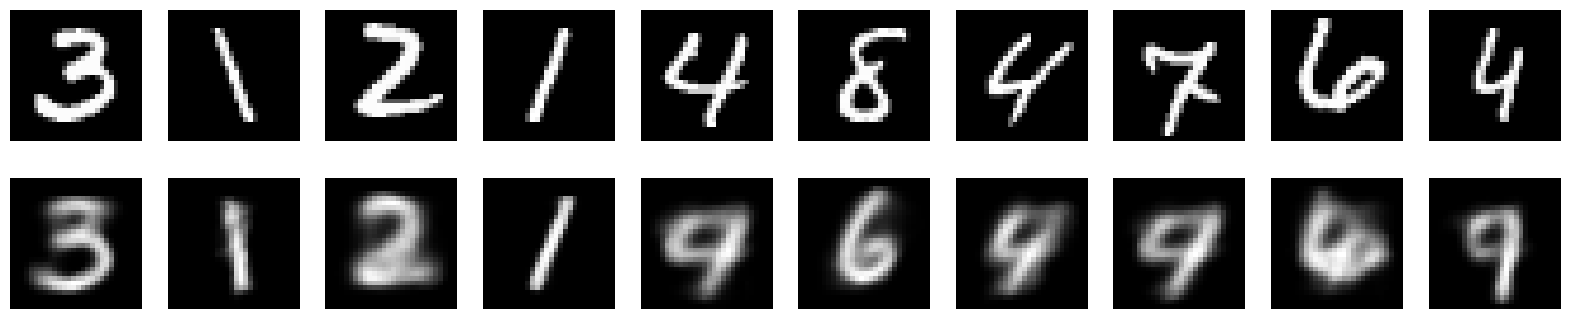

In [5]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)

encoded_imgs = encoder.predict(x_test, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Testing the encoder part 2

Here we try the encoder with hand written digit images not used for training after adding some noise to the image.

first row autoencoder input, second row associated autoencoder output


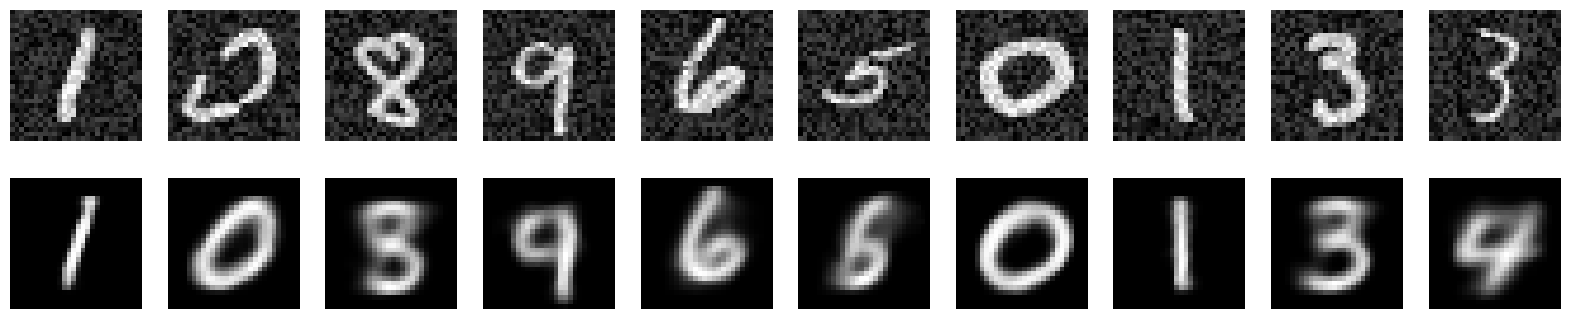

In [6]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)
x_test_noisy = x_test + (np.random.random(x_test.shape) - 0.5) * 0.4

encoded_imgs = encoder.predict(x_test_noisy, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Testing the encoder part 3

Here we try the encoder with hand written digit images not used for training after corrupting some of the pixels (setting to 0 which corresponds to black).

first row autoencoder input, second row associated autoencoder output


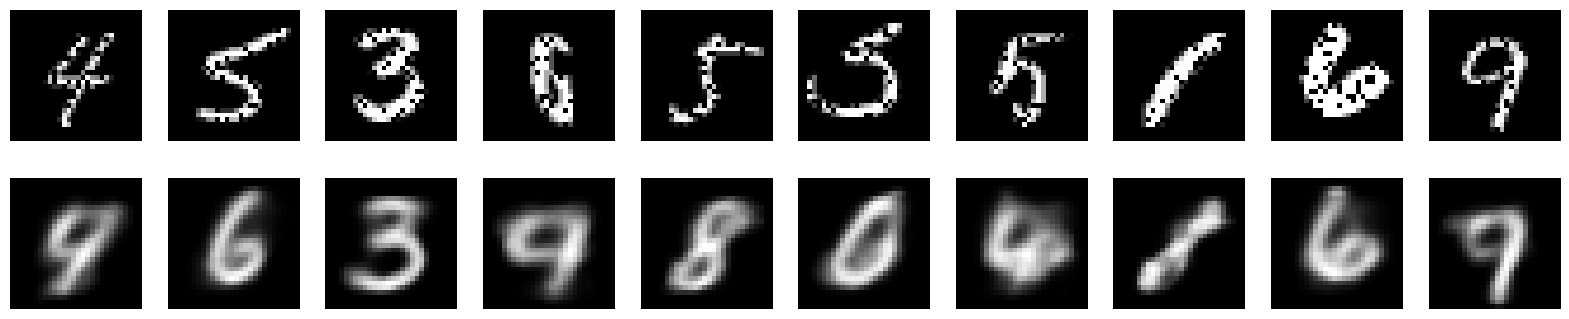

In [7]:
n = 10  # How many digits we will display from the test set

np.random.shuffle(x_test)
x_test_corrupted = x_test * np.round((np.random.random(size=x_test.shape) + 0.3))

encoded_imgs = encoder.predict(x_test_corrupted, verbose=False)
decoded_imgs = decoder.predict(encoded_imgs, verbose=False)

print('first row autoencoder input, second row associated autoencoder output')

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test_corrupted[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    # Display reconstruction
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
plt.show()

#### Feeding the decoder with arbitrary numbers to generate visual patterns

We generate a set of random numbers matching the input of the decoder (i.e. the size fo the latent space) and we display the image generated at the output of the decoder. The random numbers are generated between 0 and 1, then we apply a scaling and offset factors. Mind that we should match aim for values to not too far from the latent space range (displayed below).

In [8]:
encoded_imgs = encoder.predict(x_train, verbose=False)
print('latent space min, max, mean values',np.min(encoded_imgs),np.max(encoded_imgs),np.mean(encoded_imgs))

latent space min, max, mean values -7.2089033 4.185261 0.028994625


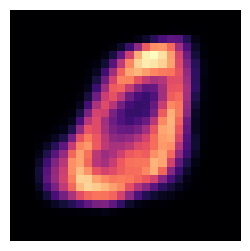

In [9]:
scale = 10.0 # change the scaling factor (positive flot numbers)
offset = -0.5 # change the offset factor (positive or negative flot numbers)

rnd = (np.random.rand(1, latent_dim) + offset) * scale

decoded_img = decoder.predict(rnd, verbose=False)
                               
plt.figure(figsize=(3, 3))
plt.imshow(decoded_img.reshape(28, 28), cmap='magma') # change the colormal to 'inferno', 'jet', or 'plasma'
plt.axis('off')
plt.show()

#### Feeding the decoder with a sequence of arbitrary numbers to generate a sequence of visual patterns

Here we do the same as above but repeating the generation for n number of times (ufing a for loop). The generated images are displayed all at once, row by row (left to right, top to bottom).

Things that we can try:
* generate a fixed random number outside the loop and update scale/offset with the loop index.
* generate a fixed random number outside the loop and  scale/offset with the loop index'.
* integrate the training in the loop, completing one epoch at each iteration (set a slow n, this will be slow, or use a very small subset of the training set). This can be combined with an increase in the learning rate (to make the model potentially unstable and never converge).
* try with another dataset.
* ...


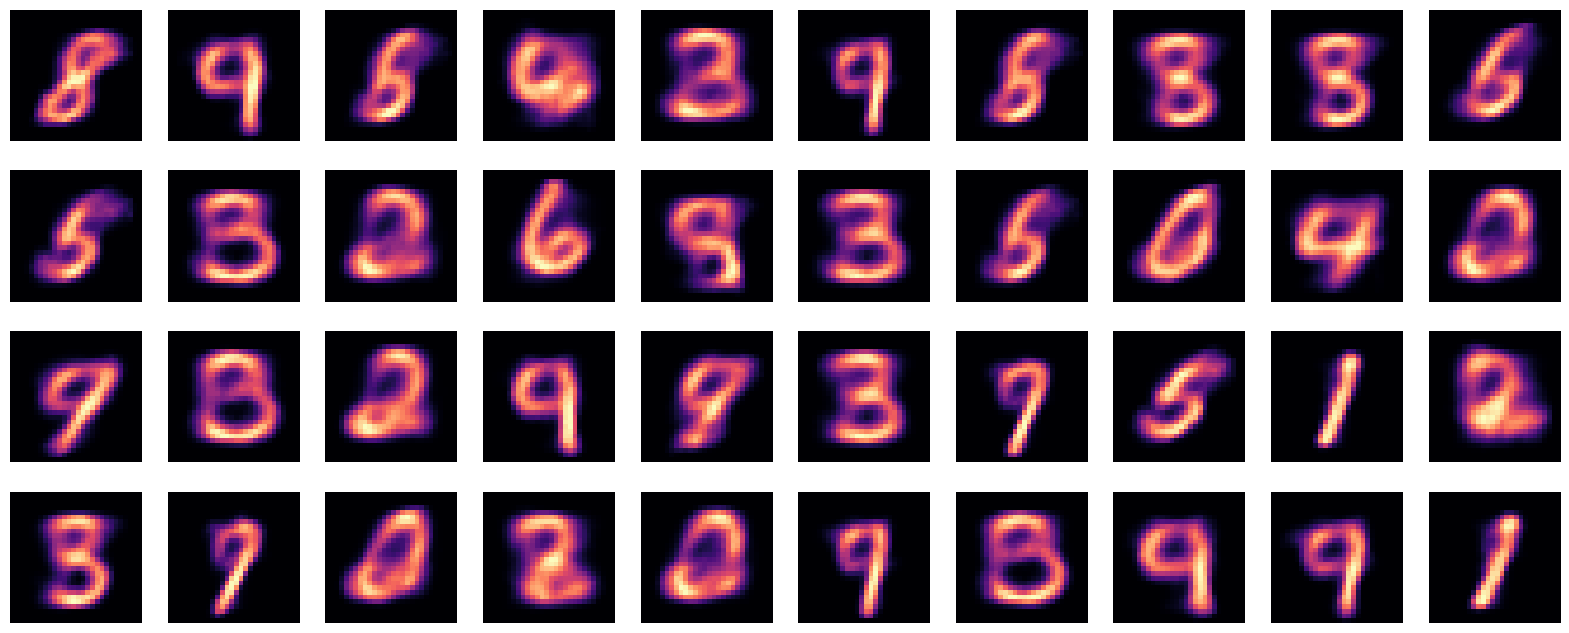

In [10]:
n = 40  # How many digits we will display (must be a multiple of 10)

if n % 10 != 0:
    sys.exit("use n integer multiple of 10")

rows = int(n / 10)
cols = int(n / rows)

plt.figure(figsize=(20, 2*rows))


for i in range(n):
    
    scale = 3 # change the scaling factor (positive flot numbers)
    offset = -0.5 # change the offset factor (positive or negative flot numbers)
    rnd = (np.random.rand(1, latent_dim) + offset) * scale
    
    #temp = rnd * i/n
    #rnd = 0.8*(rnd) + 0.2*(np.random.rand(1, encoding_dim))*scale
    
    decoded_img = decoder.predict(rnd, verbose=False)
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(decoded_img.reshape(28, 28), cmap='magma')
    plt.axis('off')

#### Feeding the decoder with a sequence of arbitrary numbers to generate an animated GIF of visual patterns

Same concept as above, but here we save the sequence of images in an animated GIF (out.gif)


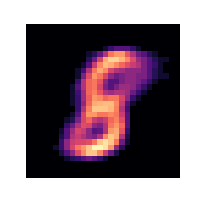

In [11]:
n = 40  # How many digits we will display generate and sequence in a gif

tempdir = './temp'
if os.path.isdir(tempdir):
    for f in os.listdir(tempdir):
        os.remove(os.path.join(tempdir, f))
    os.rmdir(tempdir)

os.makedirs(tempdir)

for i in range(n):
    
    scale = 3 # change the scaling factor (positive flot numbers)
    offset = -0.5 # change the offset factor (positive or negative flot numbers)
    rnd = (np.random.rand(1, latent_dim) + offset) * scale
    
    #temp = rnd * i/n
    #rnd = 0.8*(rnd) + 0.2*(np.random.rand(1, encoding_dim))*scale
    
    decoded_img = decoder.predict(rnd, verbose=False)
    plt.figure(figsize=(2, 2)) # change to a bigger or smaller gif (but original image resolution will stay 28x28)
    plt.imshow(decoded_img.reshape(28, 28), cmap='magma')
    plt.axis('off')
    plt.savefig(tempdir+'/image'+str(i)+'.png')
    plt.close()

gif_file = 'out.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob(tempdir+'/image*'+'.png')
    filenames = natsorted(filenames)
    for filename in filenames:
        image = imageio.v3.imread(filename)
        writer.append_data(image)
        
embed.embed_file(gif_file)

#### Display a 2D manifold of the digits sampled in the latent space

We can sample points uniformly on the 2D latent space, and generate an image with the decoder for each point, creating a visual representation of the digits in the latent space.


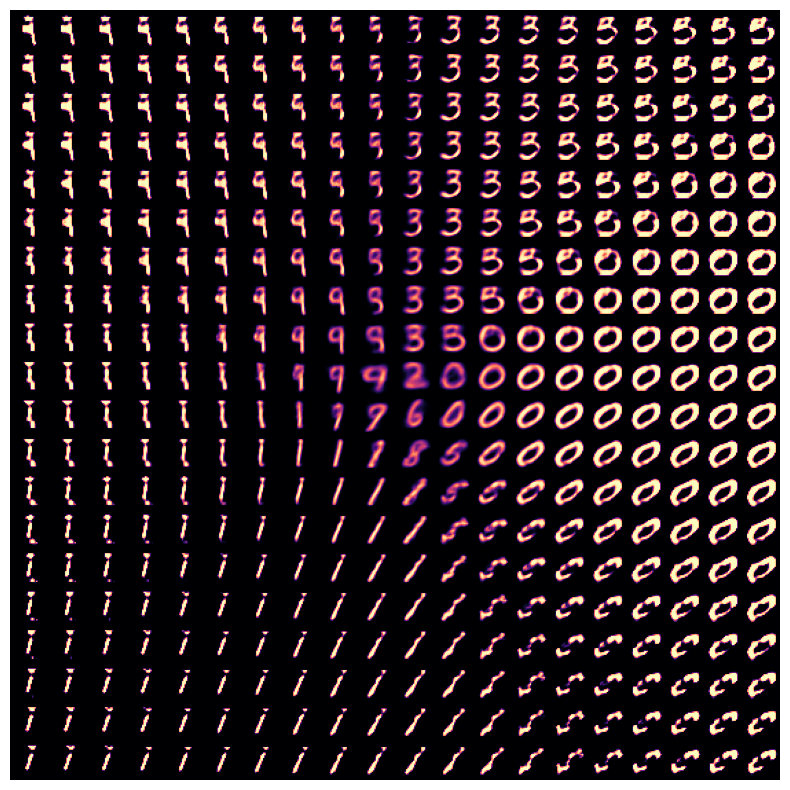

In [12]:
n = 20  # figures on each axis
mean_std_range = 10 # we will sample n points within [-mean_std_range, mean_std_range] mean and standard deviations

image_size = 28
figure = np.zeros((image_size * n, image_size * n))
grid_x = np.linspace(-mean_std_range, mean_std_range, n)
grid_y = np.linspace(-mean_std_range, mean_std_range, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(image_size, image_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='magma')
plt.axis('off')
plt.show()

### Follow up activities

1. Replace the MINST dataset with sound/music related data.